In this project we are interested in estimating converegence properties of Stochastic Gradient MCMC algorithms (SG-MCMC). These algorithms are well known for efficiently computing posterior estimates when the data set does not fit into memory (out-of-core), however the estimates tend to be biased. 

One such approach is the Stochastic Gradient Langevin Dynamics (SGLD) sampler, which makes use of a Langevin diffusion to approximate the costly gradient and likelihood evaluations using a mini-batch of the data. 

The SGLD algorithm produces aymptotically biased posterior estimates and therefore it is not straightforward to assess convergence of the underlying Markov chain [1]. Therefore, in this project we are interested in comparing standard diagnostic tools such as $\hat R$ and $N_{eff}$ of SGLD with such estimates from HMC or NUTS.

[1] Christopher Nemeth & Paul Fearnhead (2021) Stochastic Gradient Markov Chain Monte Carlo, Journal of the American Statistical Association, 116:533, 433-450, DOI: 10.1080/01621459.2020.1847120

## Dataset

We consider a multi-class OCR digits classification problem. The MNIST dataset consists of $70000$ labeled data points test points, each one consisting of $28 \times 28$ grayscale pixels. 

![MNIST Examples](MnistExamples.png)


In [1]:
import sys
sys.path.append("../") 

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

The data set is split into train and test sets, and the images are flattened into a $784-$dimensional vector. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [8]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [9]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

The data set contains tuples $(x_i,y_i)$, where $x_i \in \mathbb R^{784}$ and $y \in \{0,1,2,\ldots\,9\}$. The model estimate the probability of example $i$ belonging to one of the 10 classes, as follows: 

$\hat y_i = \frac{\exp(o_i)}{\sum_k \exp(o_k)}$

Conversely, the observed data is transformed using a linear transformation $o_i= W^T \times x_i + b$. Therefore the model parameters are $\theta=(W,b)$ and the log-likelihood is:


$\ell(\theta) = \sum_{i=1}^{|D|} \sum_{j=0}^{10} \log \left( \frac{\exp(o_i)}{\sum_{k} \exp(o_k) } \right)^{I\{y^{(i)}=j\}}$

The priors for the first (non-hierarchical) model are set weakly informative $p(\theta)=p(W,b)=\prod_i^{784 \times 10} \text{normal}(0,10)\times \prod_i^{10} \text{normal}(0,10)$

In [25]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import mxnet.gluon.probability as mxp

class softmax():
    
    def __init__(self,_hyper,ctx=mx.cpu()):
        self.hyper=_hyper
        self.ctx=ctx
        self.LOG2PI = np.log(2.0 * np.pi)

        
    def softmax(self, y_linear):
        exp = nd.exp(y_linear-nd.max(y_linear, axis=1).reshape((-1,1)))
        norms = nd.sum(exp, axis=1).reshape((-1,1))
        return exp / norms

    def predict(self, par,X,prob=False):
        y_hat=self.forward(par,X_train=X)   
        return y_hat	

    def forward(self,par, **args):
        for k,v in args.items():
            if k=='X_train':
                X=v
        y_linear = nd.dot(X, par['weights']) + par['bias']
        yhat = self.softmax(y_linear)
        cat=mxp.Categorical(1,prob=yhat)
        return cat
     
    def negative_log_prior(self, par,**args):
        log_prior=nd.zeros(shape=1,ctx=self.ctx)
        for var in par.keys():
            means=nd.zeros(par[var].shape,ctx=self.ctx)
            sigmas=nd.ones(par[var].shape,ctx=self.ctx)*np.sqrt(self.hyper['alpha'])
            param_prior=mxp.normal.Normal(loc=means,scale=sigmas)
            log_prior=log_prior-nd.mean(param_prior.log_prob(par[var]).as_nd_ndarray())
        return log_prior
    
    def negative_log_likelihood(self,par,**args):
        for k,v in args.items():
            if k=='X_train':
                X=v
            elif k=='y_train':
                y=v
        y_hat = self.forward(par,X_train=X)
        return -nd.mean(y_hat.log_prob(y).as_nd_ndarray())
        
    def loss(self,par,**args):
        log_like=self.negative_log_likelihood(par,**args)
        log_prior=self.negative_log_prior(par,**args)
        return log_like+log_prior

An alternative hierarchical model considers an inverse gamma distribution  such as:

The priors for the first (non-hierarchical) model are set weakly informative $p(\theta)=p(W,b)=\prod_i^{784 \times 10} \text{normal}(0,\sigma_i)\times \prod_j^{10} \text{normal}(0,\sigma_j)\times \prod_k^{784 \times 100}\frac{1}{gamma(1,1)}$

The normal prior is set to have a small variance since the original data was re-scaled into the interval $[0,1]$

In [47]:
class hierarchical_softmax(softmax):
    
    def negative_log_prior(self, par,**args):
        log_prior=nd.zeros(shape=1,ctx=self.ctx)
        prior=mxp.Gamma(shape=1.0,scale=1.0)
        for var in par.keys():
            means=nd.zeros(par[var].shape,ctx=self.ctx)
            sigmas=1./prior.sample(par[var].shape).copyto(self.ctx)
            param_prior=mxp.normal.Normal(loc=means,scale=sigmas)
            log_prior=log_prior
                -nd.mean(param_prior.log_prob(par[var]).as_nd_ndarray())
                -nd.mean(prior.log_prob(sigmas).as_nd_ndarray()) # we still need to introduce the log-det-jacobian
                                                                 # of the inverse transformation 
        return log_prior

# Stochastic Gradient Langevin Dynamics

In [12]:
import mxnet as mx
from mxnet import nd, autograd, gluon

model_ctx=mx.gpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [13]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax


model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [30]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [15]:
par,loss,posterior_samples=inference.fit(epochs=100,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 100/100 [09:09<00:00,  5.49s/it]


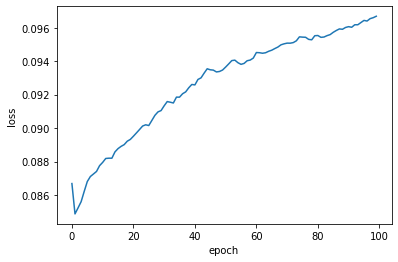

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [18]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1406
           1       0.95      0.95      0.95      1557
           2       0.89      0.85      0.87      1427
           3       0.84      0.84      0.84      1414
           4       0.87      0.89      0.88      1385
           5       0.83      0.78      0.80      1269
           6       0.89      0.92      0.91      1337
           7       0.89      0.89      0.89      1480
           8       0.79      0.81      0.80      1339
           9       0.85      0.84      0.85      1386

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



In [31]:
from hamiltonian.models.softmax import hierarchical_softmax

par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
model2=hierarchical_softmax(hyper,ctx=model_ctx)
inference=sgld(model2,par,step_size=0.05,ctx=model_ctx)

In [32]:
par2,loss2,posterior_samples2=inference.fit(epochs=100,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 100/100 [11:30<00:00,  6.91s/it]


In [37]:
y_pred=model2.predict(par2,nd.array(X_test,ctx=model_ctx))

In [38]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1406
           1       0.95      0.94      0.94      1557
           2       0.86      0.84      0.85      1427
           3       0.84      0.83      0.84      1414
           4       0.83      0.86      0.85      1385
           5       0.81      0.76      0.79      1269
           6       0.89      0.91      0.90      1337
           7       0.89      0.88      0.89      1480
           8       0.77      0.77      0.77      1339
           9       0.80      0.83      0.81      1386

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.86      0.86     14000



# Posterior Diagnostics

In [61]:
import arviz as az

In [81]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [82]:
posterior_samples_numpy['bias'].shape

(1, 100, 10)

In [83]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [85]:
ess=az.ess(dataset)

In [89]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 100.0 100.0 ... 100.0
    bias           (bias_dim_0) float64 100.0 100.0 100.0 ... 100.0 100.0 100.0

# Conclusion

Unfortunately this project requires a lot of coding and testing so I couldn't get the expected results yet. However, in the future these results will allow to evaluate different priors and modelling assumptions.  